# GESTURE RECOGNITION PROJECT
- Our aim is to build a 3D Convolutional Network and a CNN+RNN architecture that will be able to predict the 5 gestures correctly. 

## PROBLEM STATEMENT : 
A home electronics company manufactures state of the art smart televisions. We have to develop a cool feature in the smart-TV that can recognise __five different gestures__ performed by the user which will help users control the TV without using a remote. Each video is a sequence of 30 frames (or images).

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- __Thumbs Up__ - Increase the volume
- __Thumbs Down__ - Decrease the volume
- __Left Swipe__ - 'Jump' backwards 10 seconds
- __Right Swipe__ - 'Jump' forward 10 seconds
- __Stop__ - Pause the movie<br>

For analysing videos using neural networks, __two types of architectures__ are used commonly.<br> 
- One is the __standard CNN + RNN architecture__ in which you pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN.
- The other popular architecture used to process videos is a natural extension of CNNs - __a 3D convolutional network__.

#### OBJECTIVES :
__Generator:__ To define a generator that should be able to take a batch of videos as input. Steps like cropping, resizing and normalization are to be performed.

__Model:__ To develop a model that is able to train the data without any errors.


- __We have tried various models with 3D convolutional networks and 2D CNN+RNN networks. Among those models, we propose the final model here with 2D convolutional + GRU network. Also, we implemented the transfer learning model to get better accuracy.__
- __Number of parameters in this proposed model is very less compared to other models that are tried previously.__

## FINAL MODEL

In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import os
from imageio import imread
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500) 

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

__We set the random seed so that the results don't vary drastically.__

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [10]:
# Function to plot the training/validation accuracies/losses.

def plot_model(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [5]:
class BuildModel:
    
    # Function to initialize the paths
    def path_initialization(self,source_path):
        self.train_doc = np.random.permutation(open(source_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(source_path + '/' + 'val.csv').readlines())
        self.train_path = source_path + '/' + 'train'
        self.val_path =  source_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # Function to initialize some values      
    def values_initialization(self,image_height,image_width,sampled_frames,batch_size,num_of_epochs):
        self.image_height=image_height
        self.image_width=image_width
        self.sampled_frames=sampled_frames
        self.batch_size=batch_size
        self.num_epochs=num_of_epochs 
        self.channels=3
        self.num_classes=5
        
    # Data generator function    
    def generator(self, source_path, folder_list, batch_size, aug=False):
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        num_batches = len(folder_list)//batch_size
        mod_batch = len(folder_list)%batch_size
        while True:
            t = np.random.permutation(folder_list)
            for batch in range(num_batches): 
                batch_data = np.zeros((batch_size, self.sampled_frames, self.image_height, self.image_width, self.channels)) 
                batch_labels = np.zeros((batch_size, 5)) 
                if(aug):
                    data_aug = np.zeros((batch_size, self.sampled_frames, self.image_height, self.image_width, self.channels))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in                    
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        if(aug):
                            
                            # Cropping the images
                            # If the image is not of square shape,lets crop it into square so that the gesture is more focussed
                            
                            if image.shape[1] > image.shape[0]:
                                difference_value = image.shape[1] - image.shape[0]
                                crop_start = difference_value//2
                                crop_end = crop_start + image.shape[0]
                                image = image[:, crop_start:crop_end]
                            elif image.shape[0] > image.shape[1]:
                                difference_value = image.shape[0] - image.shape[1]
                                crop_start = difference_value//2
                                crop_end = crop_start + image.shape[1]
                                image = image[crop_start:crop_end,:]                   

                            # Resizing the images
                            image_resized=resize(image, (self.image_height, self.image_width, self.channels))

                            # Normalization                    
                            data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                            data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                            data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        else:
                            # Resizing the image
                            image_resized=resize(image, (self.image_height, self.image_width, self.channels))

                            # Normalization                    
                            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255                    

                    batch_labels[folder, int(t[folder+(batch*batch_size)].strip().split(';')[2])] = 1
                    if(aug):
                        batch_data = data_aug
                yield batch_data, batch_labels

            # Code for the remaining data points which are left after full batches
            if(mod_batch!=0):
                batch_data = np.zeros((batch_size, self.sampled_frames, self.image_height, self.image_width, self.channels)) 
                batch_labels = np.zeros((batch_size, 5)) 
                if(aug):
                    data_aug = np.zeros((batch_size, self.sampled_frames, self.image_height, self.image_width, self.channels))
                for folder in range(mod_batch): # iterate over the mod_batch
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in                    
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)                    
                        if(aug):
                            
                            # Cropping the images
                            # If the image is not of square shape,lets crop it into square so that the gesture is more focussed
                            
                            if image.shape[1] > image.shape[0]:
                                difference_value = image.shape[1] - image.shape[0]
                                crop_start = difference_value//2
                                crop_end = crop_start + image.shape[0]
                                image = image[:, crop_start:crop_end]
                            elif image.shape[0] > image.shape[1]:
                                difference_value = image.shape[0] - image.shape[1]
                                crop_start = difference_value//2
                                crop_end = crop_start + image.shape[1]
                                image = image[crop_start:crop_end,:]                   

                            # Resizing the images
                            image_resized=resize(image, (self.image_height, self.image_width, self.channels))

                            # Normalization                    
                            data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                            data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                            data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        else:
                            # Resizing the image
                            image_resized=resize(image, (self.image_height, self.image_width, self.channels))

                            # Normalization                    
                            batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                            batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                            batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    batch_labels[folder, int(t[folder+(batch*batch_size)].strip().split(';')[2])] = 1
                    if(aug):
                        batch_data = data_aug
                yield batch_data, batch_labels
            
    def CNN_GRU_Model_definition(self):
        
        # 2D CONVOLUTIONAL NETWORK + GRU

        # Number of TimeDistributed 2D convolutional Layers = 4
        # With GRU layer
        # 2 Dense TimeDistributed layers
        # 1 Dense Softmax output layer
        # Kernel size = (3,3)
        # Pool size = (2,2)
        # With dropout layers
        # Learning rate = 0.0002
        # Activation function - 'relu'
        
        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(self.sampled_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2))))

        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2)))) 
        
        model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2)))) 
        
        model.add(TimeDistributed(Flatten()))

        model.add(TimeDistributed(Dense(64, activation='relu')))
        model.add(TimeDistributed(Dense(128, activation='relu')))
        model.add(Dropout(0.30))

        model.add(GRU(32))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes,activation='softmax'))
            
        # Compile the model
        
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model
    
    
    def TransferLearning_GRU_Model_definition(self, mobilenet_transfer):
        
        # Transfer learning + GRU
        # With dropout layers 
        # Activation function - 'relu'
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.sampled_frames, self.image_height, self.image_width, self.channels)))        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(Dropout(0.30))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(16))
        model.add(Dropout(0.35))
        
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.40))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile the model
        
        optimiser = optimizers.Adam(learning_rate=0.0003)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model
    
    
    def Model_Training(self, model, factor_value, patience_lr, patience_early_stop, augment=False):
        
        curr_dt_time = datetime.datetime.now()
        
        # Train generator and Validation generator
        
        train_generator = self.generator(self.train_path, self.train_doc, self.batch_size,aug=augment)
        val_generator = self.generator(self.val_path, self.val_doc, self.batch_size)
        
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # Model checkpoint to save the best model
        
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                                     save_weights_only=False, mode='auto')
        
        # Reduce learning rate when a metric has stopped improving.This callback monitors a quantity 
        # and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
            
        LR = ReduceLROnPlateau(monitor="val_loss",
            factor=factor_value,
            patience=patience_lr,
            verbose=0,
            mode="auto",
            cooldown=0,
            min_lr=0)
        
        # Early stopping is a method that allows to specify an arbitrary large number of training epochs.
        # And stops training once the model performance stops improving on a hold out validation dataset.
            
        EarlyStop = EarlyStopping(monitor='val_loss',
            min_delta=0,
            patience=patience_early_stop,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=False)
        
        # List of callbacks
        
        callbacks_list = [checkpoint, LR, EarlyStop]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
            
        # Fit the model on the data
            
        fitted_model = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, epochs = self.num_epochs,
                       verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps,
                       class_weight=None, workers=1, initial_epoch=0)
        return fitted_model

### FINAL MODEL - 2D CNN + GRU Network Model

- __2D convolutional network + GRU model__ 
- __With augmentation__
- __With dropout layers__
- __4 2D-convolutional layers__
- __2 Dense TimeDistributed layers__
- __1 GRU layer__
- __1 softmax Dense output layer__
- __Activation function__ : 'relu'
- __Optimizer__ : 'Adam' 
- __Learning rate__ : 0.0002
- __Image height__ = 100
- __Image width__ = 100
- __Batch size__ = 20
- __Number of epochs__ = 70
- __Metrics__ : Accuracy

In [6]:
# Passing source path for initialising all the required paths

source_path = 'C:/Users/gayth/Project_data'

# Frame indices to be selected among the available 30 frames per sequence

img_idx = [3,6,9,11,13,15,17,19,21,24,27]
num_of_selected_frames = len(img_idx)

# Instantiating the object for BuildModel() class

Model_Conv2D_GRU = BuildModel()

# Image height = 100
# Image width = 100
# Batch_size = 20
# Number of epochs = 65

Model_Conv2D_GRU.path_initialization(source_path)
Model_Conv2D_GRU.values_initialization(100,100,num_of_selected_frames,20,65)

# Define the 2D Conv + GRU network model using function 'CNN_GRU_Model_definition'

Model_1 = Model_Conv2D_GRU.CNN_GRU_Model_definition()
Model_1.summary()

# Pass the model to train the data and obtain the results using Model_Training() function

Model_ConvGRU = Model_Conv2D_GRU.Model_Training(Model_1,0.5,10,30,augment=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 11, 98, 98, 8)    224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 49, 49, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 11, 47, 47, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 11, 23, 23, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 11, 21, 21, 16)   2

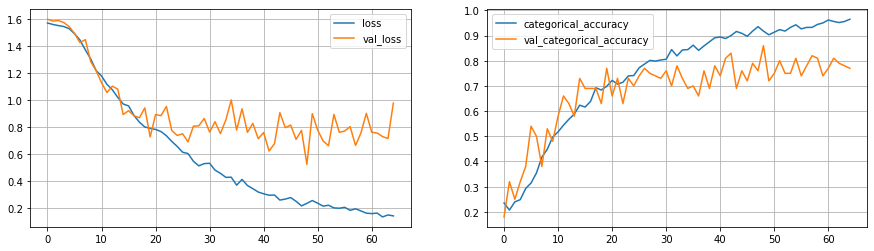

In [11]:
plot_model(Model_ConvGRU)

## Inference : 

- __The final model has total number of parameters : 65,221 which is lesser compared to other models that are tried.__
- __At 49th epoch, we obtained the following best results:__
>- __Training accuracy : 0.9176__
>- __Validation accuracy : 0.8600__
>- __Training loss : 0.2340__
>- __Validation loss : 0.5227__
- __The learning rate was 0.0002 till 37th epoch and it gets reduced to 0.0001 for the following epochs according to the parameters mentioned in the 'ReduceLROnPlateau'. Further, at 60th epoch, it still gets reduced to 0.00005.__

## MODEL WITH TRANSFER LEARNING AND GRU

- __Transfer learning + GRU model__ 
- __With augmentation__
- __With dropout layers__
- __Activation function__ : 'relu'
- __Optimizer__ : 'Adam' 
- __Image height__ = 100
- __Image width__ = 100
- __Batch size__ = 20
- __Number of epochs__ = 25
- __Metrics__ : Accuracy
- __Here we incorporated imagenet weights from mobilenet data.__

In [12]:
# Instantiating the object for BuildModel() class

Model_transfer_GRU = BuildModel()

# Image height = 100
# Image width = 100
# Batch_size = 20
# Number of epochs = 25

Model_transfer_GRU.path_initialization(source_path)
Model_transfer_GRU.values_initialization(100,100,num_of_selected_frames,20,25)

from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

# Define the transfer learning + GRU network model using function 'TransferLearning_GRU_Model_definition()'
                                         
Model_2 = Model_transfer_GRU.TransferLearning_GRU_Model_definition(mobilenet_transfer)
Model_2.summary()

# Pass the model to train the data and obtain the results using Model_Training() function

Model_transfer_learning = Model_transfer_GRU.Model_Training(Model_2,0.7,5,10,augment=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 11, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 11, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 dropout_2 (Dropout)         (None, 11, 1, 1, 1024)    0         
                                                                 
 time_distributed_14 (TimeDi  (None, 11, 1024)         0         
 stributed)                                           

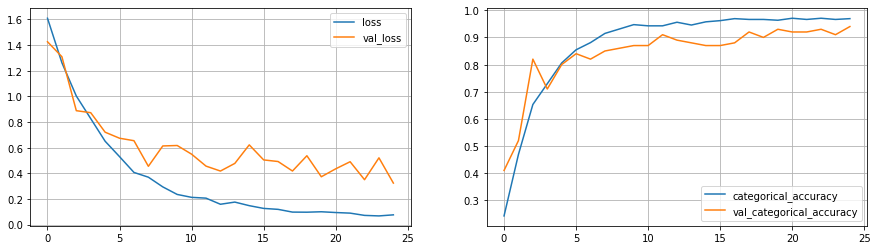

In [13]:
plot_model(Model_transfer_learning)

## Inference :
- __As we can see the model with transfer learning performs the best with higher accuracy rate in both training and validation sets as well.__
- __Number of parameters : 3,284,389__
- __At 25th epoch, we obtained the following best results:__
>- __Training accuracy : 0.9691__
>- __Validation accuracy : 0.9400__
>- __Training loss : 0.0753__
>- __Validation loss : 0.3231__
- __The learning rate was 0.0003 till 18th epoch and it gets reduced to 0.0002 for the following epochs according to the parameters mentioned in the 'ReduceLROnPlateau'.__
- __Number of parameters involved in this model is too high and hence if at all the computational efficacies are tolerable, we can go with this model otherwise the previous model can be used which has lesser number of parameters.__